# 第三章第四节 数据增强——transforms&albumentations

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from matplotlib import pyplot as plt

def transform_invert(img_, transform_train):
    """
    将data 进行反transfrom操作
    :param img_: tensor
    :param transform_train: torchvision.transforms
    :return: PIL image
    """
    if 'Normalize' in str(transform_train):
        norm_transform = list(filter(lambda x: isinstance(x, transforms.Normalize), transform_train.transforms))
        mean = torch.tensor(norm_transform[0].mean, dtype=img_.dtype, device=img_.device)
        std = torch.tensor(norm_transform[0].std, dtype=img_.dtype, device=img_.device)
        img_.mul_(std[:, None, None]).add_(mean[:, None, None])

    img_ = img_.transpose(0, 2).transpose(0, 1)  # C*H*W --> H*W*C
    if 'ToTensor' in str(transform_train) or img_.max() < 1:
        img_ = img_.detach().numpy() * 255

    if img_.shape[2] == 3:
        img_ = Image.fromarray(img_.astype('uint8')).convert('RGB')
    elif img_.shape[2] == 1:
        img_ = Image.fromarray(img_.astype('uint8').squeeze())
    else:
        raise Exception("Invalid img shape, expected 1 or 3 in axis 2, but got {}!".format(img_.shape[2]) )

    return img_

class COVID19Dataset(Dataset):
    def __init__(self, root_dir, txt_path, transform=None):
        """
        获取数据集的路径、预处理的方法
        """
        self.root_dir = root_dir
        self.txt_path = txt_path
        self.transform = transform
        self.img_info = []  # [(path, label), ... , ]
        self.label_array = None
        self._get_img_info()

    def __getitem__(self, index):
        """
        输入标量index, 从硬盘中读取数据，并预处理，to Tensor
        :param index:
        :return:
        """
        path_img, label = self.img_info[index]
        img = Image.open(path_img).convert('L')

        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def __len__(self):
        if len(self.img_info) == 0:
            raise Exception("\ndata_dir:{} is a empty dir! Please checkout your path to images!".format(
                self.root_dir))  # 代码具有友好的提示功能，便于debug
        return len(self.img_info)

    def _get_img_info(self):
        """
        实现数据集的读取，将硬盘中的数据路径，标签读取进来，存在一个list中
        path, label
        :return:
        """
        # 读取txt，解析txt
        with open(self.txt_path, "r") as f:
            txt_data = f.read().strip()
            txt_data = txt_data.split("\n")

        self.img_info = [(os.path.join(self.root_dir, i.split()[0]), int(i.split()[2]))
                         for i in txt_data]
        
# you can download the datasets from
# https://pan.baidu.com/s/18BsxploWR3pbybFtNsw5fA  code：pyto
root_dir = r"E:\pytorch-tutorial-2nd\data\datasets\covid-19-demo"  # path to datasets——covid-19-demo
img_dir = os.path.join(root_dir, "imgs")
path_txt_train = os.path.join(root_dir, "labels", "train.txt")

### Resize

In [2]:
transforms_func = transforms.Compose([
    transforms.Resize((2, 2)),
    transforms.ToTensor()
])
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data.shape, data)

torch.Size([2, 1, 2, 2]) tensor([[[[0.4510, 0.4314],
          [0.5373, 0.5294]]],


        [[[0.3804, 0.3882],
          [0.4941, 0.5294]]]])


思考为什么会报错？
提示：
1. 注意resize的size为int时的操作
2. 注意看报错信息，torch.stack....
3. 通常会resize会配CenterCrop进行使用，以此保证图像大小一致

In [3]:
transforms_func = transforms.Compose([
    transforms.Resize(5), 
    transforms.ToTensor()
])
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data.shape, data)

RuntimeError: stack expects each tensor to be equal size, but got [1, 6, 5] at entry 0 and [1, 5, 5] at entry 1

### Normalize

In [4]:
transforms_func = transforms.Compose([
    transforms.Resize((2, 2)),
    transforms.ToTensor(),
    transforms.Normalize([0.4], [0.2])  # 由于本dataset是灰度图，仅1个通道，就不在展示3通道的使用。
])
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data.shape, data)

torch.Size([2, 1, 2, 2]) tensor([[[[ 0.2549,  0.1569],
          [ 0.6863,  0.6471]]],


        [[[-0.0980, -0.0588],
          [ 0.4706,  0.6471]]]])


### FiveCrop

观察一下代码错误，可自行复制代码段到pycharm中单步调试，观察何处报错。
提示：由于compose是依次运行的，由于fivecrop返回的img不能被下一个transforms方法接收，因此报错。
代码段回顾：
def __call__(self, img):
    for t in self.transforms:
        img = t(img)
    return img

In [5]:
transforms_func = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.FiveCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.4], [0.2])  # 由于本dataset是灰度图，仅1个通道，就不在展示3通道的使用。
])
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data.shape, data)

TypeError: pic should be PIL Image or ndarray. Got <class 'tuple'>

FiveCrop的正确打开方式
代码解释：
1. transforms.Lambda(lambda crops: torch.stack([ToTensor()(crop) for crop in crops]))
Lambda是可自定义的变换操作，在这里为的是将一个list的图像堆叠为符合后续变换需要的3D-tensor形式。到了compose里，传入lambda的是fivecrop的输出，是一个长度为5的list，然后再lambda里，对这个list进行循环，每一个图像会经过totensor，然后这个list经过torch.stack，就变为了一个4D-tensor。（这里需要大家熟悉compoese的call函数里的那个for循环，各变换是依次进行的。）

2. print(data.shape, data)
dataloader将4D-tensor进行组装，增加batch的维度，得到了一个[2, 5, 1, 224, 224]的张量

3. result = model(data.view(-1, c, h, w))
因为模型的输入只能是4D-tensor，shape为 BCHW，所以需要把数据重新排一下，把crops暂时排到batch维度

In [6]:
    class TinnyCNN(nn.Module):
        def __init__(self, cls_num=2):
            super(TinnyCNN, self).__init__()
            self.convolution_layer = nn.Conv2d(1, 1, kernel_size=(3, 3))
            self.fc = nn.Linear(36, cls_num)

        def forward(self, x):
            x = self.convolution_layer(x)
            x = x.view(x.size(0), -1)
            out = self.fc(x)
            return out

    model = TinnyCNN(2)

In [7]:
from torchvision.transforms import ToTensor

transforms_func = transforms.Compose([
    transforms.Resize((10,10)),
    transforms.FiveCrop(8),
    transforms.Lambda(lambda crops: torch.stack([ToTensor()(crop) for crop in crops])),
    transforms.Normalize([0.4], [0.2])  # 由于本dataset是灰度图，仅1个通道，就不在展示3通道的使用。
])
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data.shape)
    
    # 模型推理
    bs, ncrops, c, h, w = data.size()
    result = model(data.view(-1, c, h, w)) # fuse batch size and ncrops
    print(result.shape, result)
    result_avg = result.view(bs, ncrops, -1).mean(1) # 平均5个结果，当然根据任务，可以选取最大值、取最小值等操作。
    
    print(result_avg.shape, result_avg)
    ###

torch.Size([2, 5, 1, 8, 8])
torch.Size([10, 2]) tensor([[-0.2078, -0.2838],
        [ 0.1508, -0.1229],
        [-0.2396, -0.0646],
        [ 0.0722, -0.1632],
        [ 0.0690, -0.1743],
        [-0.1796, -0.1750],
        [ 0.0204,  0.0458],
        [-0.1626, -0.0326],
        [-0.0280, -0.3778],
        [-0.0049, -0.2122]], grad_fn=<AddmmBackward0>)
torch.Size([2, 2]) tensor([[-0.0311, -0.1618],
        [-0.0709, -0.1504]], grad_fn=<MeanBackward1>)


FiveCrop的使用就到这里，TenCrop不再演示，使用方法完全一致，主要要求大家深刻理解transforms.Compose是如何工作的，理解transforms方法前后的配套关系。

### 其余API学习示范

In [ ]:
授人以渔：其余的二十多个不在一一介绍，只需要到官方文档上查看接口，并利用本代码运行，观察效果即可。

torch.Size([2, 1, 224, 224])
(224, 224)


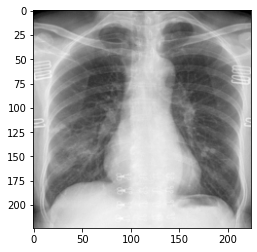

In [12]:
transforms_func = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data.shape)
    img_tensor = data[0, ...]     # C H W
    img = transform_invert(img_tensor, transforms_func)
    print(img.size)
    plt.imshow(img, cmap="gray")
    plt.show()

#### RandomVerticalFlip

torch.Size([2, 1, 224, 224])
(224, 224)


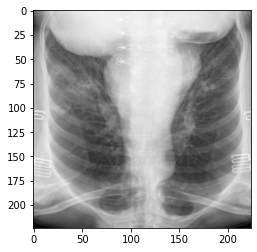

In [14]:
transforms_func = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(p=1),  # 为了效果展示，概率设置为1， 通常设置为0.5
    transforms.ToTensor()
])
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data.shape)
    img_tensor = data[0, ...]     # C H W
    img = transform_invert(img_tensor, transforms_func)
    print(img.size)
    plt.imshow(img, cmap="gray")
    plt.show()

#### transforms.CenterCrop

torch.Size([2, 1, 128, 128])
(128, 128)


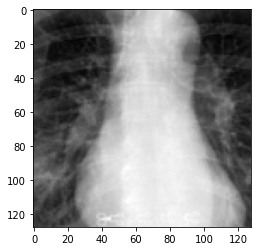

In [19]:
transforms_func = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(128),
    transforms.ToTensor()
])
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data.shape)
    img_tensor = data[0, ...]     # C H W
    img = transform_invert(img_tensor, transforms_func)
    print(img.size)
    plt.imshow(img, cmap="gray")
    plt.show()

In [ ]:
不在一一展示，可结合官方文档自行学习
ColorJitter
GaussianBlur
RandomPerspective
RandomRotation
RandomAffine
RandomCrop
RandomResizedCrop
RandomInvert
RandomPosterize
RandomSolarize
RandomAdjustSharpness
RandomAutocontrast
RandomEqualize
TrivialAugmentWide

### RandomChoice

可以看到变换后的图片，要么填充10个像素，要么垂直翻转，没有即垂直翻转，又填充10个像素的。
这就是randomchoice的作用，从一系列中选择1个。

torch.Size([1, 1, 244, 244])
(244, 244)


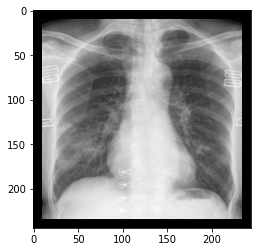

torch.Size([1, 1, 244, 244])
(244, 244)


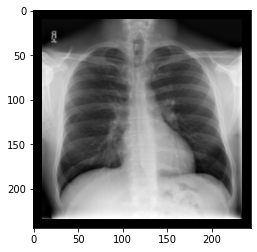

torch.Size([1, 1, 224, 224])
(224, 224)


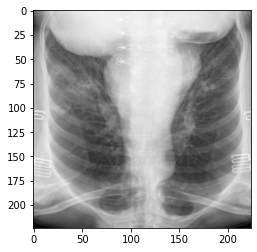

torch.Size([1, 1, 224, 224])
(224, 224)


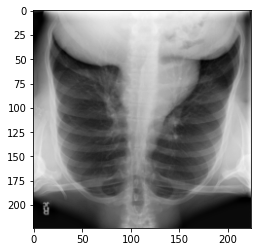

torch.Size([1, 1, 244, 244])
(244, 244)


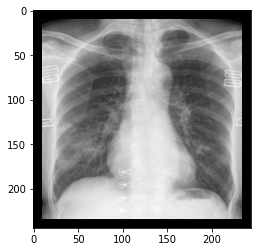

torch.Size([1, 1, 244, 244])
(244, 244)


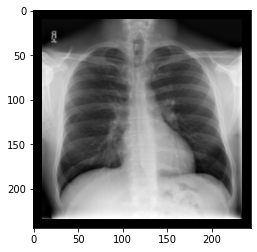

In [23]:
transforms_func = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomChoice([transforms.Pad(10), transforms.RandomVerticalFlip(p=1)]),
    transforms.ToTensor()
])
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=1)
for epoch in range(3):
    for data, labels in train_loader:
        print(data.shape)
        img_tensor = data[0, ...]     # C H W
        img = transform_invert(img_tensor, transforms_func)
        print(img.size)
        plt.imshow(img, cmap="gray")
        plt.show()

### RandomOrder

随机排序指的是这一系列变换的顺序会随机打乱。  
通过以下代码可以看到如果是先填充再反转，则填充的黑色像素在图像的底部。  
如果是先反转，再填充，则填充的黑色像素区域在图像的顶部。

torch.Size([1, 1, 324, 224])
(224, 324)


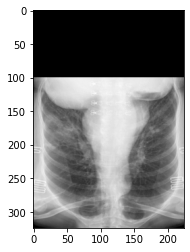

torch.Size([1, 1, 324, 224])
(224, 324)


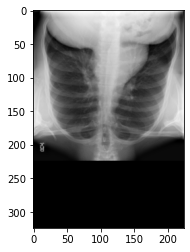

torch.Size([1, 1, 324, 224])
(224, 324)


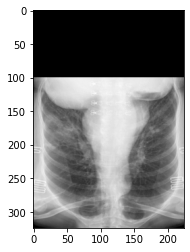

torch.Size([1, 1, 324, 224])
(224, 324)


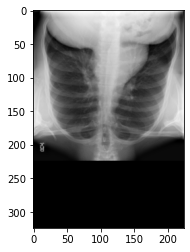

torch.Size([1, 1, 324, 224])
(224, 324)


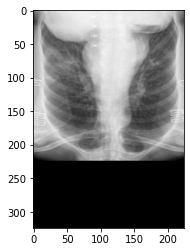

torch.Size([1, 1, 324, 224])
(224, 324)


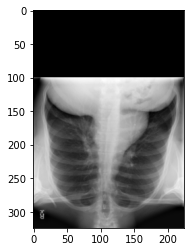

In [12]:
transforms_func = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomOrder([transforms.Pad((0, 100, 0, 0)), transforms.RandomVerticalFlip(p=1)]),
    transforms.ToTensor()
])
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=1)
for epoch in range(3):
    for data, labels in train_loader:
        print(data.shape)
        img_tensor = data[0, ...]     # C H W
        img = transform_invert(img_tensor, transforms_func)
        print(img.size)
        plt.imshow(img, cmap="gray")
        plt.show()

### RandomApply

randomapply与RandomChoice的区别仅在于它将一组变换看成一个选择单位，RandomChoice是一次选一个，RandomApply是一次选一组（list）.  
可以看到下图中，要么执行缩放 + (填充、反转)，要么只执行缩放。这里的(填充、反转)就是一组变换。

torch.Size([1, 1, 324, 224])
(224, 324)


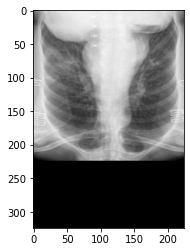

torch.Size([1, 1, 224, 224])
(224, 224)


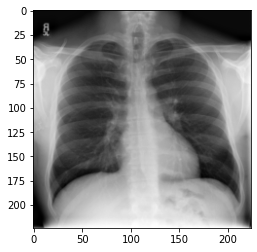

torch.Size([1, 1, 324, 224])
(224, 324)


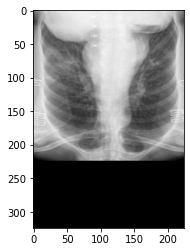

torch.Size([1, 1, 224, 224])
(224, 224)


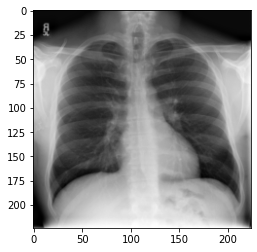

torch.Size([1, 1, 224, 224])
(224, 224)


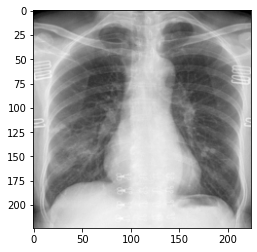

torch.Size([1, 1, 324, 224])
(224, 324)


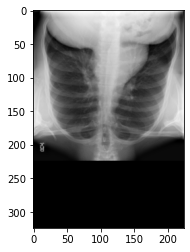

torch.Size([1, 1, 224, 224])
(224, 224)


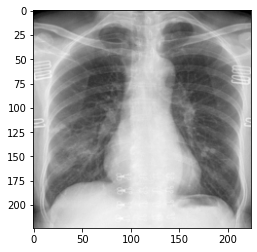

torch.Size([1, 1, 224, 224])
(224, 224)


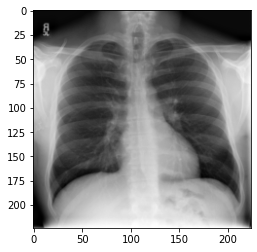

torch.Size([1, 1, 224, 224])
(224, 224)


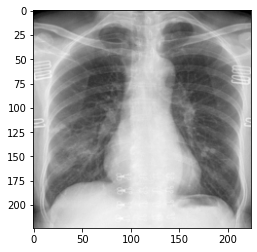

torch.Size([1, 1, 324, 224])
(224, 324)


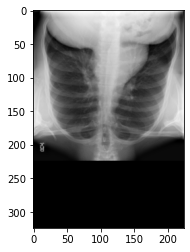

In [19]:
transforms_func = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomApply([transforms.Pad((0, 100, 0, 0)), transforms.RandomVerticalFlip(p=1)], p=0.5),
    transforms.ToTensor()
])
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=1)
for epoch in range(5):
    for data, labels in train_loader:
        print(data.shape)
        img_tensor = data[0, ...]     # C H W
        img = transform_invert(img_tensor, transforms_func)
        print(img.size)
        plt.imshow(img, cmap="gray")
        plt.show()

### AutoAugmentPolicy

torch.Size([1, 1, 4095, 3342])
(3342, 4095)


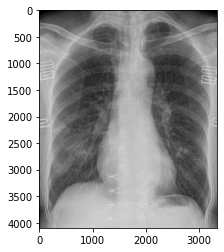

torch.Size([1, 1, 1024, 1024])
(1024, 1024)


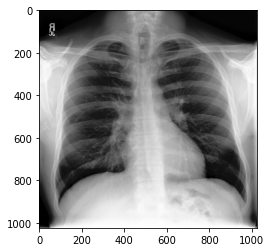

torch.Size([1, 1, 4095, 3342])
(3342, 4095)


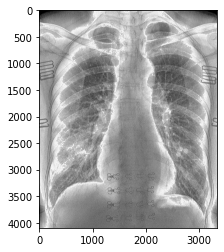

torch.Size([1, 1, 1024, 1024])
(1024, 1024)


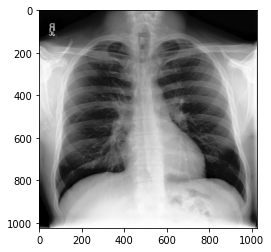

torch.Size([1, 1, 4095, 3342])
(3342, 4095)


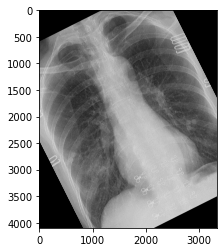

torch.Size([1, 1, 1024, 1024])
(1024, 1024)


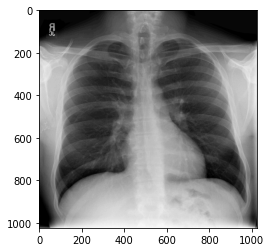

torch.Size([1, 1, 4095, 3342])
(3342, 4095)


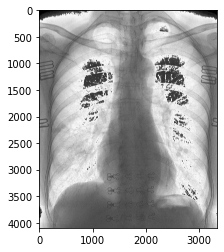

torch.Size([1, 1, 1024, 1024])
(1024, 1024)


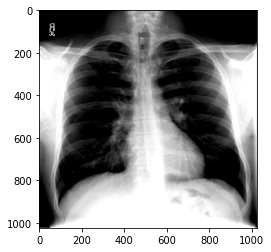

torch.Size([1, 1, 4095, 3342])
(3342, 4095)


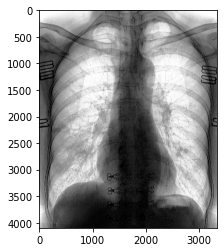

torch.Size([1, 1, 1024, 1024])
(1024, 1024)


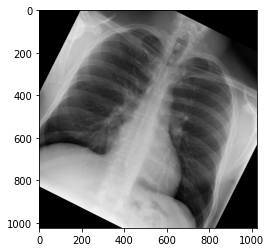

In [25]:
policy = transforms.AutoAugmentPolicy.CIFAR10
# policy = transforms.AutoAugmentPolicy.IMAGENET  
# policy = transforms.AutoAugmentPolicy.SVHN

transforms_func = transforms.Compose([
    transforms.AutoAugment(policy),
    transforms.ToTensor(),
    transforms.Normalize([0.4], [0.2])  # 由于本dataset是灰度图，仅1个通道，就不在展示3通道的使用。
])
# transforms_func = transforms.AutoAugment(policy)
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=1)
for epoch in range(5):
    for data, labels in train_loader:
        print(data.shape)
        img_tensor = data[0, ...]     # C H W
        img = transform_invert(img_tensor, transforms_func)
        print(img.size)
        plt.imshow(img, cmap="gray")
        plt.show()

### RandAugment

torch.Size([1, 1, 4095, 3342])
(3342, 4095)


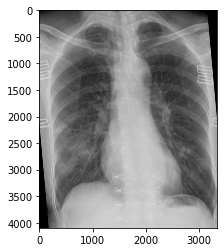

torch.Size([1, 1, 1024, 1024])
(1024, 1024)


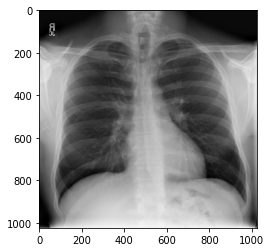

torch.Size([1, 1, 4095, 3342])
(3342, 4095)


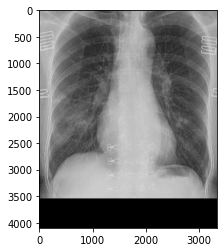

torch.Size([1, 1, 1024, 1024])
(1024, 1024)


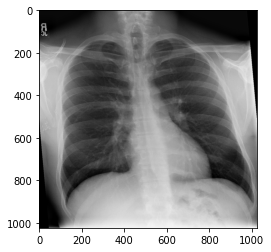

torch.Size([1, 1, 4095, 3342])
(3342, 4095)


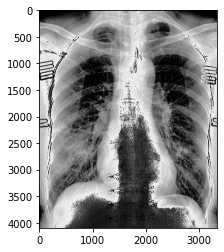

torch.Size([1, 1, 1024, 1024])
(1024, 1024)


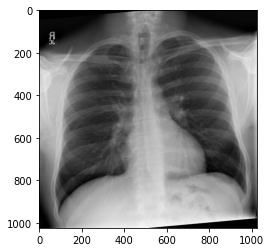

In [31]:

transforms_func = transforms.Compose([
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize([0.4], [0.2])  # 由于本dataset是灰度图，仅1个通道，就不在展示3通道的使用。
])
# transforms_func = transforms.AutoAugment(policy)
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=1)
for epoch in range(3):
    for data, labels in train_loader:
        print(data.shape)
        img_tensor = data[0, ...]     # C H W
        img = transform_invert(img_tensor, transforms_func)
        print(img.size)
        plt.imshow(img, cmap="gray")
        plt.show()

### TrivialAugmentWide

torch.Size([1, 1, 224, 224])
(224, 224)


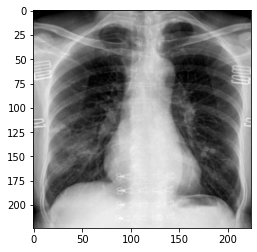

torch.Size([1, 1, 224, 224])
(224, 224)


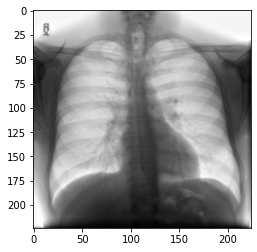

torch.Size([1, 1, 224, 224])
(224, 224)


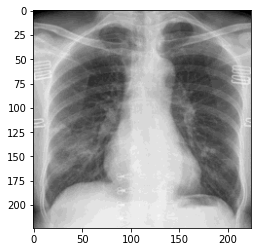

torch.Size([1, 1, 224, 224])
(224, 224)


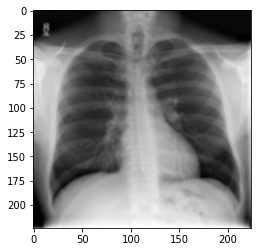

torch.Size([1, 1, 224, 224])
(224, 224)


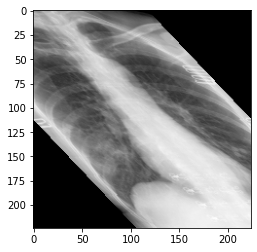

torch.Size([1, 1, 224, 224])
(224, 224)


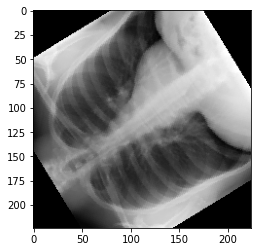

In [30]:

transforms_func = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize([0.4], [0.2])  # 由于本dataset是灰度图，仅1个通道，就不在展示3通道的使用。
])
# transforms_func = transforms.AutoAugment(policy)
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=1)
for epoch in range(3):
    for data, labels in train_loader:
        print(data.shape)
        img_tensor = data[0, ...]     # C H W
        img = transform_invert(img_tensor, transforms_func)
        print(img.size)
        plt.imshow(img, cmap="gray")
        plt.show()